# Pylops - Marchenko redatuming by iterative substitutions

Let's consider the Marchenko equations:

$$
\mathbf{f^-}  =  \Theta \mathbf{R} \mathbf{f_d^+} + \Theta \mathbf{R} \mathbf{f_m^+} \\
\mathbf{f_m^+} = \Theta \mathbf{R^*} \mathbf{f^-}
$$

where $\Theta = \Theta^{-t_d+\epsilon}_{t_d-\epsilon}$.

One way of solving those equations is by rearranging them into a matrix-vector form and apply **direct inversion** (via e.g., LSQR):

$$
        \begin{bmatrix}
           \Theta \mathbf{R} \mathbf{f_d^+}  \\
           \mathbf{0}
        \end{bmatrix} =
        \mathbf{I} -
        \begin{bmatrix}
           \mathbf{0}  &   \Theta \mathbf{R}   \\
           \Theta \mathbf{R^*} & \mathbf{0}
        \end{bmatrix}
        \begin{bmatrix}
           \mathbf{f^-}  \\
           \mathbf{f_m^+}
        \end{bmatrix}
$$

Alternatively, we can solve the two original equations by **iterative substitution**. This is equivalent to first plugging $\mathbf{f^-}$ in the first equation:

$$
\mathbf{f_m^+} =  \Theta \mathbf{R^*} (\Theta \mathbf{R} \mathbf{f_d^+} + \Theta \mathbf{R} \mathbf{f_m^+})
$$

and isolating $\mathbf{f_m^+}$:

$$
(\mathbf{I} - \Theta \mathbf{R^*}\Theta \mathbf{R}) \mathbf{f_m^+} =  \Theta \mathbf{R^*} \Theta \mathbf{R} \mathbf{f_d^+}
$$

We can then expand the term within parenthesis as a Neumann series and write:

$$
\mathbf{f^+} = \sum_{k=0}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \mathbf{f_d^+}
$$

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

## Inputs

Input parameters 

In [2]:
inputfile = '../data/marchenko/input.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

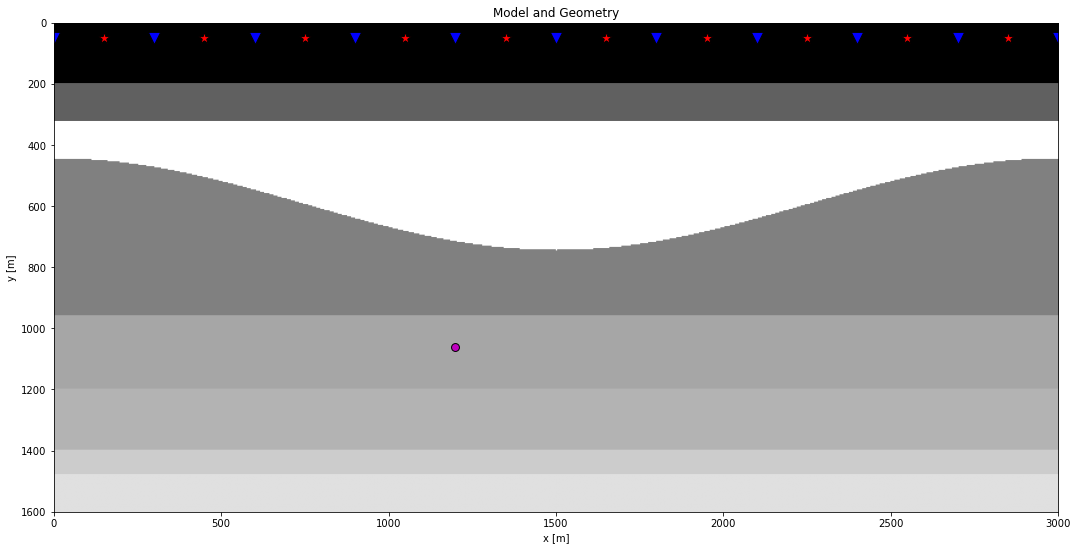

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)
t2 = np.concatenate([-np.flipud(t), t[1:]])

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [6]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

In [7]:
print(R.max())
print(G0sub.max())

0.3754
2577738.4579874733


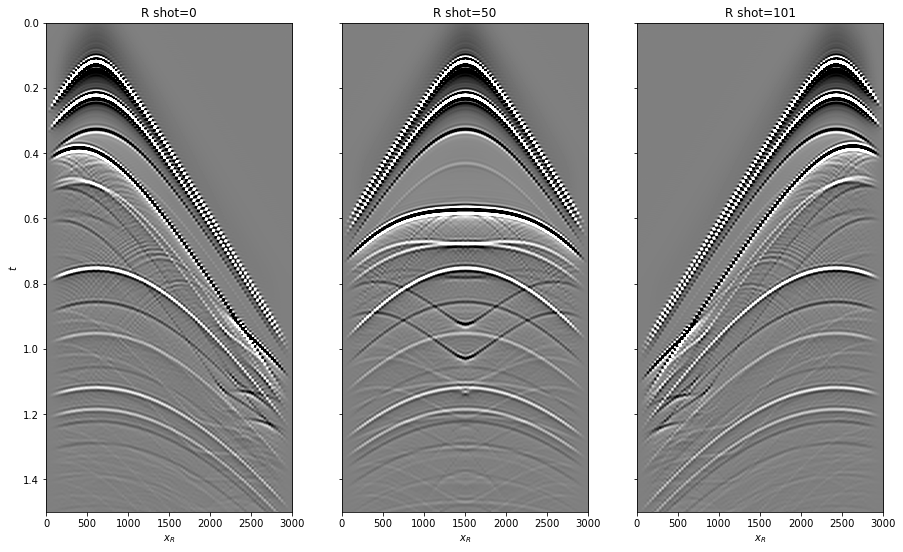

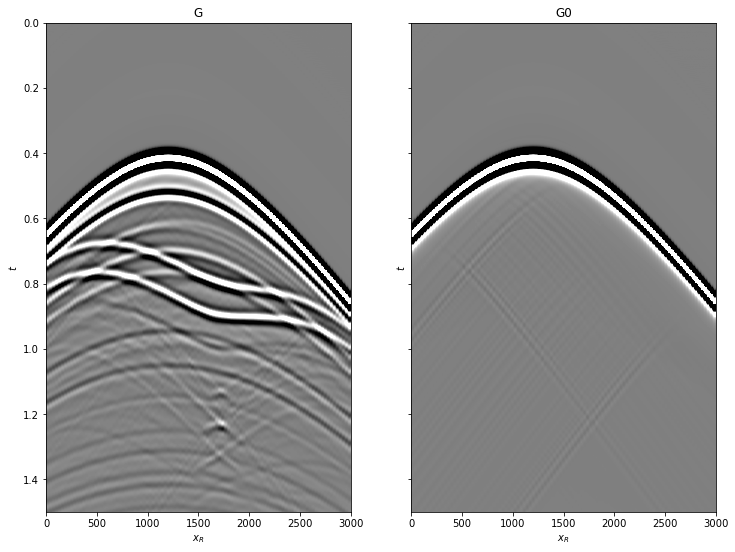

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

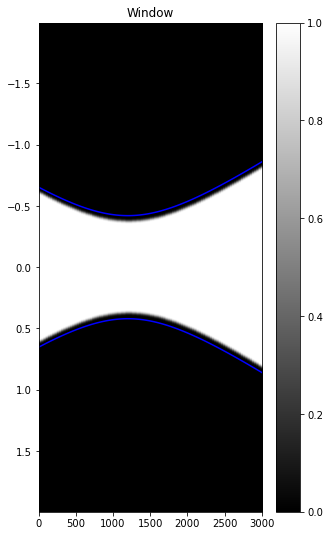

In [9]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

## Inversion

In [13]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True,)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
Rollop = Roll(dims=(2*nt-1, nr),
              axis=0, shift=-1)

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Create Marchenko operator

In [14]:
Wop = Diagonal(w.T.flatten())
Iop = Identity(nr*(2*nt-1))

Mop = VStack([HStack([Iop, -1*Wop*Rop]),
              HStack([-1*Wop*Rollop*R1op, Iop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

dottest(Gop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^H(Opu)=-742.5809960241372 - u^H(Op^Hv)=-742.5809960241372
Dot test passed, v^H(Opu)=190.34667902912867 - u^H(Op^Hv)=190.34667902912892


Run standard redatuming as benchmark

In [15]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

Create data, adjoint and inverse focusing functions

In [16]:
d = Wop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, nr), np.zeros((2*nt-1, nr))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 322998 rows and 322998 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.983e+07  2.983e+07    1.0e+00  3.5e-08
     1  0.00000e+00   1.311e+07  1.311e+07    4.4e-01  9.2e-01   1.1e+00  1.0e+00
     2  0.00000e+00   7.406e+06  7.406e+06    2.5e-01  3.9e-01   1.8e+00  2.2e+00
     3  0.00000e+00   5.479e+06  5.479e+06    1.8e-01  3.3e-01   2.1e+00  3.4e+00
     4  0.00000e+00   3.659e+06  3.659e+06    1.2e-01  3.3e-01   2.5e+00  5.2e+00
     5  0.00000e+00   2.780e+06  2.780e+06    9.3e-02  2.6e-01   2.9e+00  6.8e+00
     6  0.00000e+00   2.244e+06  2.244e+06    7.5e-02  2.3e-01   3.2e+00  8.5e+00
     7  0.00000e+00   1.498e+06  1.498e+06    5.0e-02  2.5e-01   3.6e+00  1.1e+01
     8  0.00000e+00   1.105e+0

Add initial guess to estimated focusing functions

In [17]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)),
                                      fd_plus))

Estimate Green's functions

In [18]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

Extract up and down focusing and Green's functions from model vectors

In [19]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

## Iterative substitution

In [20]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
Rollop = Roll(dims=(2*nt-1, nr),
              axis=0, shift=-1)

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

In [21]:
f1_sub_plus = fd_plus.copy()
f1_sub_plus_updates = np.zeros((n_iter, 2*nt -1, nr))
f1_sub_plus_updates[0] = fd_plus.copy()

for i_iter in range(n_iter-1):
    f1_sub_plus = (Wop * Rollop * R1op * Wop * Rop) * f1_sub_plus.ravel()
    f1_sub_plus = f1_sub_plus.reshape(2*nt-1, nr)
    f1_sub_plus_updates[i_iter+1] = f1_sub_plus.copy()

f1_sub_plus = np.sum(f1_sub_plus_updates, axis=0)  
f1_sub_minus = Wop * Rop * f1_sub_plus.ravel()
g_sub_minus = - (f1_sub_minus.ravel() - Rop * f1_sub_plus.ravel())
g_sub_plus = f1_sub_plus.ravel() - Rollop * R1op * f1_sub_minus.ravel()

f1_sub_minus = f1_sub_minus.reshape(2*nt-1, nr)
g_sub_minus = g_sub_minus.reshape(2*nt-1, nr)
g_sub_plus = np.flipud(g_sub_plus.reshape(2*nt-1, nr))

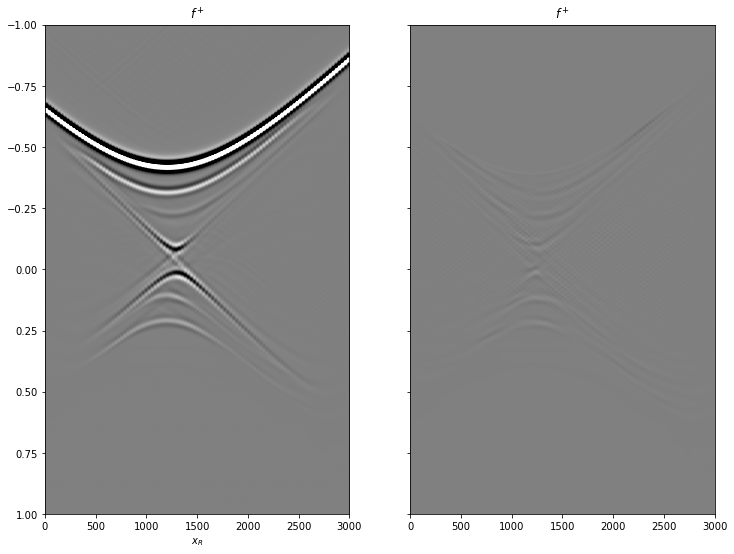

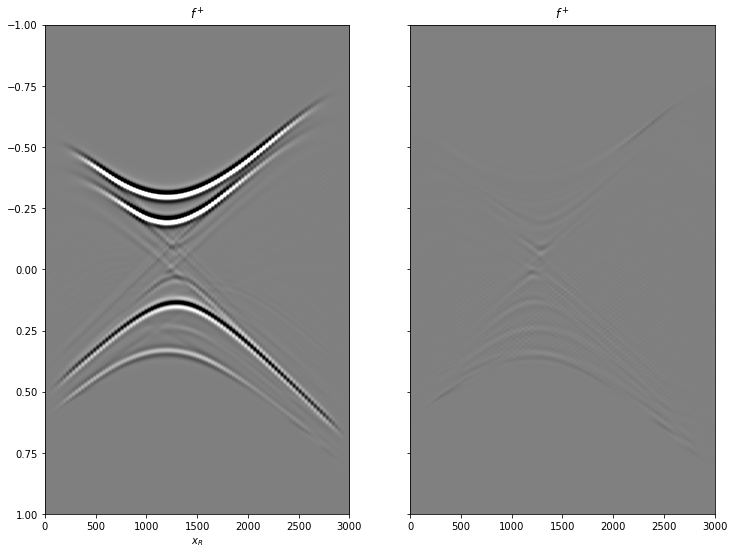

In [22]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_plus.T - f1_sub_plus, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_minus.T - f1_sub_minus, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

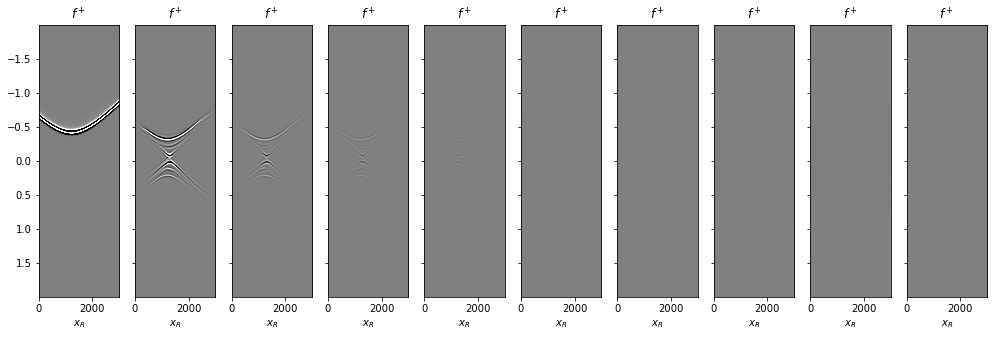

In [23]:
fig, axs = plt.subplots(1, n_iter, sharey=True, figsize=(17, 5))
for iiter in range(n_iter):
    axs[iiter].imshow(f1_sub_plus_updates[iiter], cmap='gray', vmin=-1e5, vmax=1e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
    axs[iiter].set_title(r'$f^+$')
    axs[iiter].set_xlabel(r'$x_R$')
    axs[iiter].axis('tight')

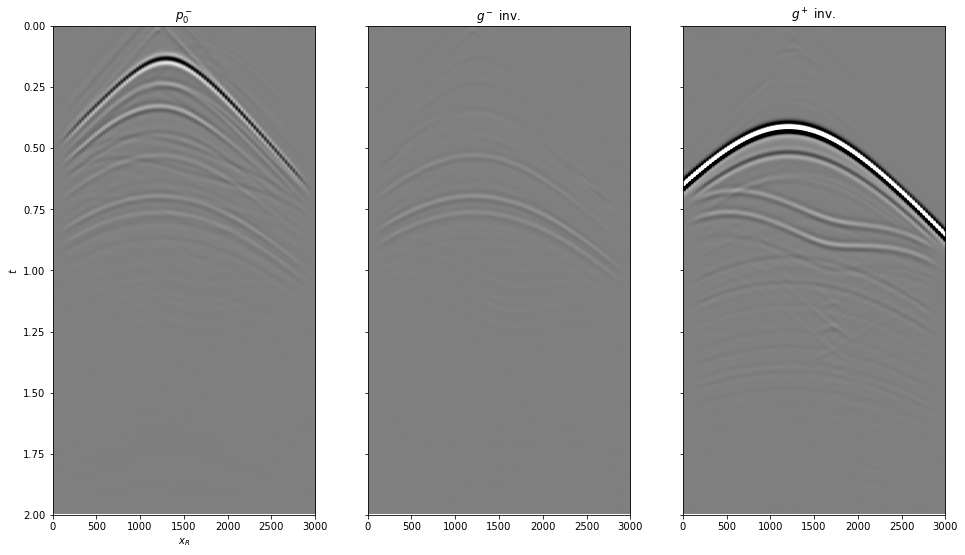

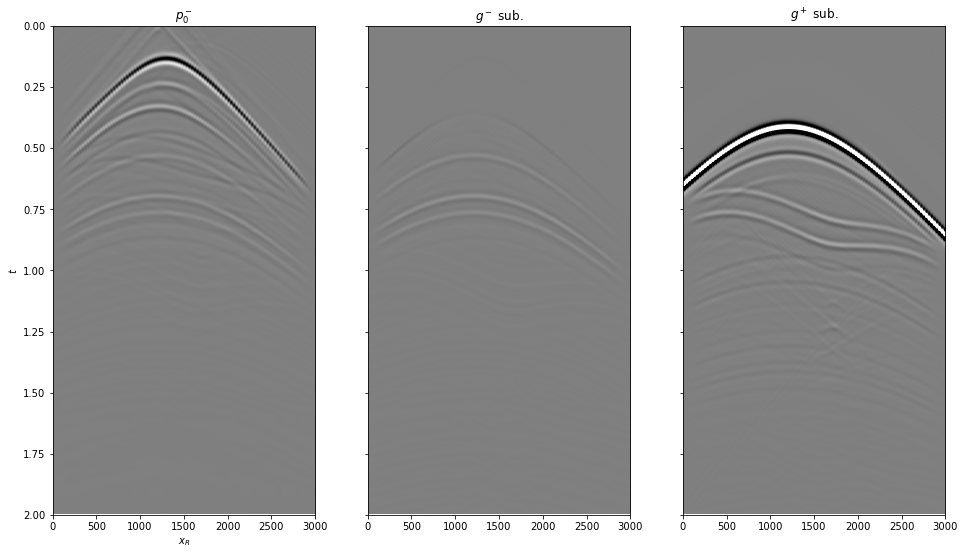

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ inv.'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ inv.'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_sub_minus, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ sub.'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_sub_plus, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ sub.'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

## Data domain demultiple

The Marchenko equations can be modified to operate directly in the data domain (instead of in the subsurface field domain):


$$
\mathbf{v^-}  = \Theta \mathbf{R} + \Theta \mathbf{R} \mathbf{v^+} \\
\mathbf{v^+} = \Theta \mathbf{R^*} \mathbf{v^-}
$$

where $\Theta = \Theta^{\epsilon}_{2t_d-\epsilon}$.

We can also solve theese equations by **iterative substitution**. This is equivalent to first plugging $\mathbf{v^-}$ in the first equation:

$$
\mathbf{v^+} =  \Theta \mathbf{R^*} (\Theta \mathbf{R} + \Theta \mathbf{R} \mathbf{v^+})
$$

and isolating $\mathbf{v^+}$:

$$
(\mathbf{I} - \Theta \mathbf{R^*} \Theta \mathbf{R}) \mathbf{v^+} =  \Theta \mathbf{R^*} \Theta \mathbf{R}
$$

We can then expand the term within parenthesis as a Neumann series and write:

$$
\mathbf{v^+} = \sum_{k=0}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \Theta \mathbf{R^*} \Theta R = \sum_{k=1}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \delta
$$

and $\mathbf{v^-}$ becomes:

$$
\mathbf{v^-} = \Theta \mathbf{R} + \Theta \mathbf{R} \sum_{k=1}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k  \delta 
$$

where $R$ is the reflection response (or $\delta$ is a spatio-temporal delta). At this point we compute $U^-$ and extract its values at time sample $t=2t_d$ (http://homepage.tudelft.nl/t4n4v/BeyondInterferometry/geo_19h.pdf):

$$
\mathbf{U^-} = \mathbf{R} + \mathbf{R} \mathbf{v^+} = \mathbf{R} + \mathbf{R} \sum_{k=1}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \delta
$$

If we repeat the same procedure for all possible $t=2t_d$, the retrived dataset is deprived of all internal multiples.

Similarly we could plug $\mathbf{v^+}$ in the second equation:

$$
\mathbf{v^-} =  \Theta \mathbf{R} + \Theta \mathbf{R} \Theta \mathbf{R^*} \mathbf{v^-}
$$

and isolating $\mathbf{v^-}$:

$$
(\mathbf{I} - \Theta \mathbf{R} \Theta \mathbf{R^*} ) \mathbf{v^-} =  \Theta \mathbf{R}
$$

We can then expand the term within parenthesis as a Neumann series and write:

$$
\mathbf{v^-} = \Theta \mathbf{R} + \sum_{k=1}^\inf (\Theta \mathbf{R} \Theta \mathbf{R^*})^k \Theta \mathbf{R}
$$

### Single depth level

We first consider a single depth level (at the bottom of the model)

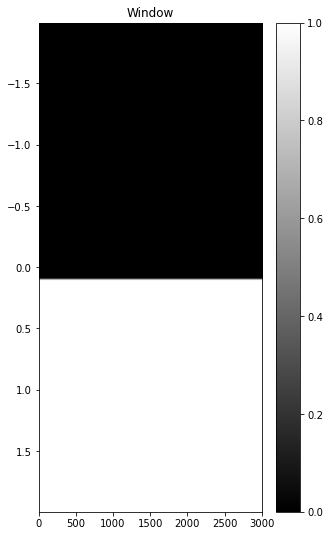

In [29]:
nsmooth = 5 # time window smoothing 
toff = 0.1

# window 
w = np.zeros((nr, 2 * nt-1))
w[:, int((toff+t[-1])/dt):] = 1

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
Wop = Diagonal(w.T.flatten())
   
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

In [30]:
Rwav = R[nr//2].T
Rwav = np.apply_along_axis(convolve, 0, Rwav, wav, mode='full')
Rwav = Rwav[wav_c:][:nt]
fd_plus = np.concatenate((np.zeros((nt-1, nr)), Rwav))

fd_plus = Wop * Rollop * R1op * Wop * fd_plus.ravel()
fd_plus = fd_plus.reshape(2*nt -1, nr)

f1_sub_plus = fd_plus.copy()
f1_sub_plus_updates = np.zeros((n_iter, 2*nt -1, nr))
f1_sub_plus_updates[0] = fd_plus.copy()

for i_iter in range(n_iter-1):
    f1_sub_plus = (Wop * Rollop * R1op * Wop * Rop) * f1_sub_plus.ravel()
    f1_sub_plus = f1_sub_plus.reshape(2*nt-1, nr)
    f1_sub_plus_updates[i_iter+1] = f1_sub_plus.copy()

f1_sub_plus = np.sum(f1_sub_plus_updates, axis=0)  
#f1_sub_minus = Wop * Rop * f1_sub_plus.ravel()
#f1_sub_minus = Rwav + f1_sub_minus.reshape(2*nt-1, nr)[nt-1:]
f1_sub_plus = np.sum(f1_sub_plus_updates, axis=0)  
f1_sub_minus = w[:, nt-1:].T * Rwav + (Wop * Rop * f1_sub_plus.ravel()).reshape(2*nt-1, nr)[nt-1:]

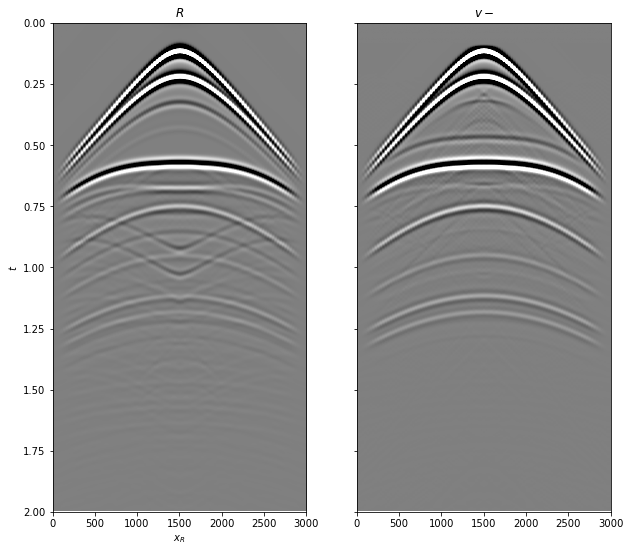

In [31]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(f1_sub_minus, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

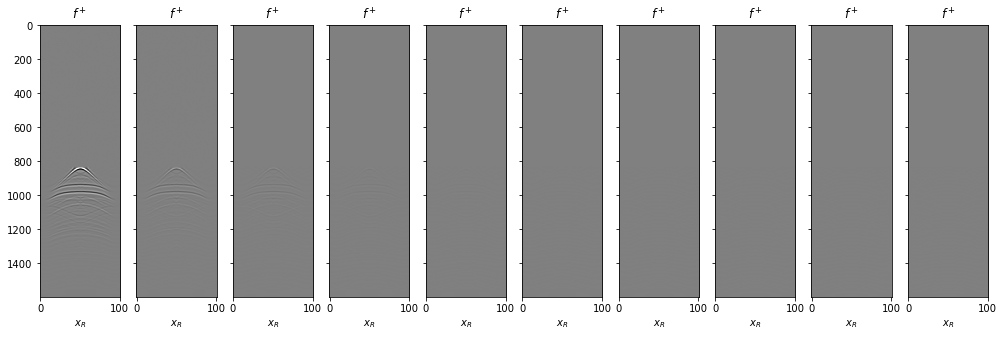

In [32]:
fig, axs = plt.subplots(1, n_iter, sharey=True, figsize=(17, 5))
for iiter in range(n_iter):
    axs[iiter].imshow(f1_sub_plus_updates[iiter], cmap='gray', vmin=-1e-1, vmax=1e-1)
    axs[iiter].set_title(r'$f^+$')
    axs[iiter].set_xlabel(r'$x_R$')
    axs[iiter].axis('tight')

Estimate v+ and then compute v-:

In [33]:
def applydatadomain_onepoint(R, travs, tmax, ir, dt, nfmax, n_iter=10, nsmooth=5):
    nr, _, nt = R.shape
    
    # Window 
    w = np.zeros((nr, 2 * nt-1))
    w[:, int((travs[0]+tmax)/dt):int((travs[1]+tmax)/dt)] = 1
    if nsmooth>0:
        smooth=np.ones(nsmooth)/nsmooth
        w  = filtfilt(smooth, 1, w)    
    Wop = Diagonal(w.T.flatten())

    # Add negative time to operators
    Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
    Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
    Rtwosided_fft = Rtwosided_fft[...,:nfmax]
    Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

    Rwav = R[ir].T
    Rwav = np.apply_along_axis(convolve, 0, Rwav, wav, mode='full')
    Rwav = Rwav[wav_c:][:nt]
    fd_plus = np.concatenate((np.zeros((nt-1, nr)), Rwav))
    
    fd_plus = Wop * Rollop * R1op * Wop * fd_plus.ravel()
    fd_plus = fd_plus.reshape(2*nt -1, nr)

    f1_sub_plus = fd_plus.copy()
    f1_sub_plus_updates = np.zeros((n_iter, 2*nt -1, nr))
    f1_sub_plus_updates[0] = fd_plus.copy()

    for i_iter in range(n_iter-1):
        f1_sub_plus = (Wop * Rollop * R1op * Wop * Rop) * f1_sub_plus.ravel()
        f1_sub_plus = f1_sub_plus.reshape(2*nt-1, nr)
        f1_sub_plus_updates[i_iter+1] = f1_sub_plus.copy()
    f1_sub_plus = np.sum(f1_sub_plus_updates, axis=0)  
    f1_sub_minus = Rop * f1_sub_plus.ravel()
    f1_sub_minus = Rwav + f1_sub_minus.reshape(2*nt-1, nr)[nt-1:]
    #f1_sub_minus = w[:, nt-1:].T * Rwav + (Wop * Rop * f1_sub_plus.ravel()).reshape(2*nt-1, nr)[nt-1:]
    return f1_sub_minus, Rwav, w

0.05


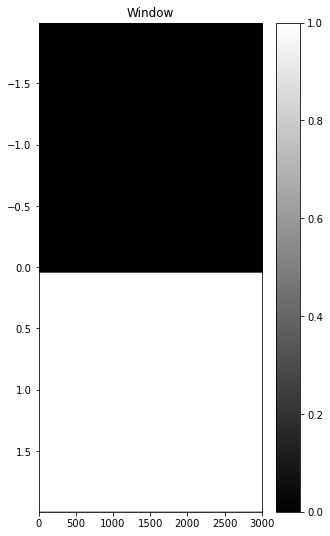

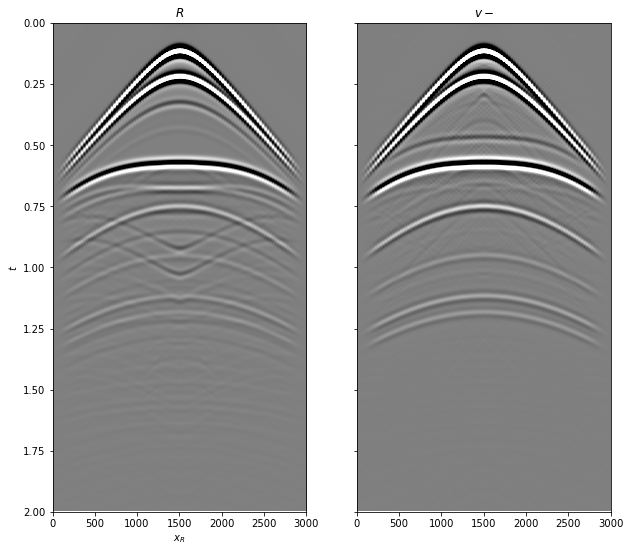

In [34]:
toff=dt*20
print(toff)
nsmooth=0
f1_minus_f, Rwav_f, w_f = \
    applydatadomain_onepoint(R, [toff, t[-1]], t[-1], nr//2, dt, nfmax, n_iter=10, nsmooth=nsmooth)
   
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w_f.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav_f, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(f1_minus_f, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

As expected, we remove the interal multiples but we also create some artefacts at small traveltime

### Multiple depth levels

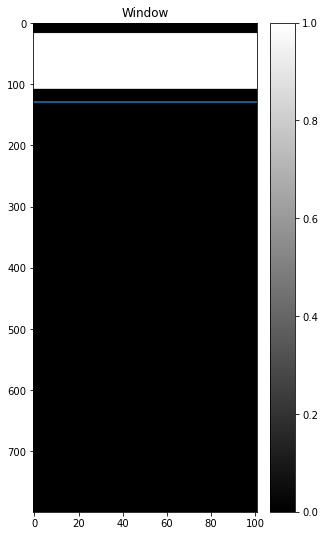

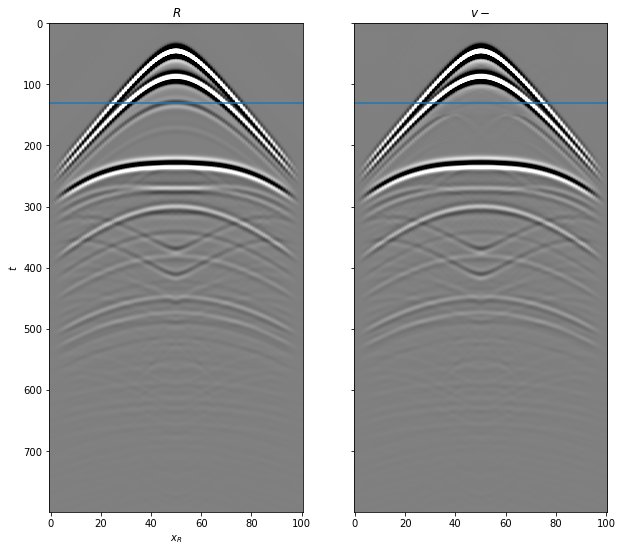

In [35]:
it0 = 130 #47

toff=dt*20
nsmooth=0
f1_minus_f, Rwav_f, w_f = \
    applydatadomain_onepoint(R, [toff, t[it0]-toff], t[-1], nr//2, dt, nfmax, n_iter=20, nsmooth=nsmooth)

fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w_f[:, nt:].T, cmap='gray')
ax.axhline(it0)
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav_f, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axhline(it0)
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(f1_minus_f, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axhline(it0)
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight');

In [36]:
Rwav = np.zeros((nt, nr))
Rwav_demultipled = np.zeros((nt, nr))

for it in range(0, nt):
    if it % 100 == 0:
        print(it, '/', nt)
    f1_minus_tmp, Rwav_tmp, w = \
        applydatadomain_onepoint(R, [toff, t[it]-toff], t[-1], nr//2, dt, nfmax, n_iter=10, nsmooth=nsmooth)
    Rwav[it] = Rwav_tmp[it]
    Rwav_demultipled[it] = f1_minus_tmp[it]

0 / 800
100 / 800
200 / 800
300 / 800
400 / 800
500 / 800
600 / 800
700 / 800


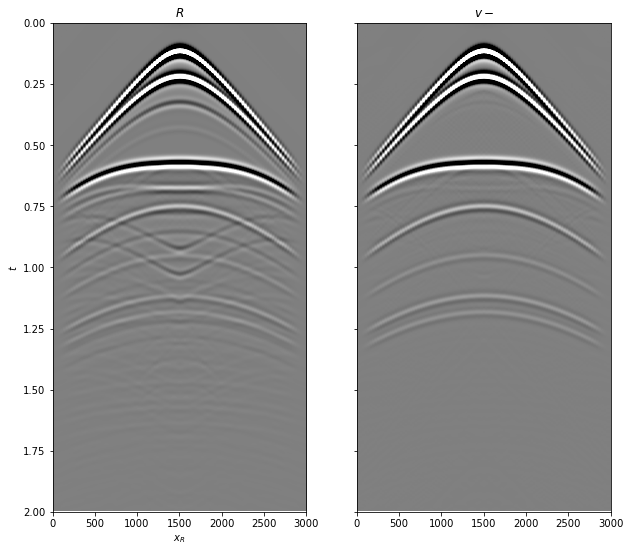

In [37]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(Rwav_demultipled, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

In [38]:
Rwav = np.zeros((nt, nr))
Rwav_demultipled_comp = np.zeros((nt, nr))

for it in range(0, nt):
    if it % 100 == 0:
        print(it, '/', nt)
    f1_minus_tmp, Rwav_tmp, w = \
        applydatadomain_onepoint(R, [toff, t[it]+toff], t[-1], nr//2, dt, nfmax, n_iter=10, nsmooth=nsmooth)
    Rwav[it] = Rwav_tmp[it]
    Rwav_demultipled_comp[it] = f1_minus_tmp[it]

0 / 800
100 / 800
200 / 800
300 / 800
400 / 800
500 / 800
600 / 800
700 / 800


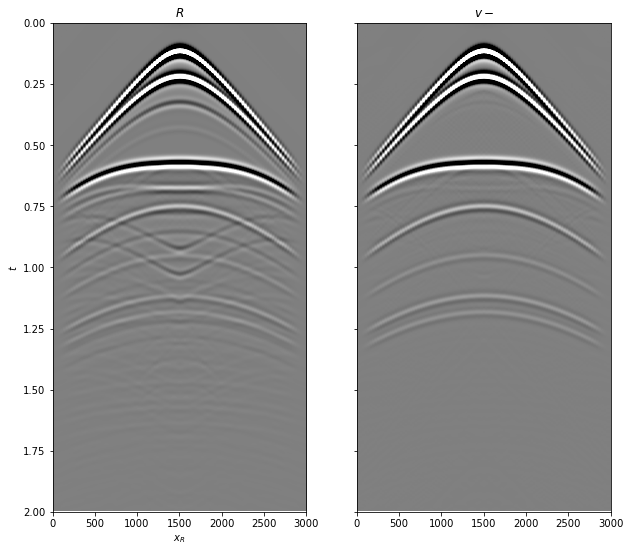

In [39]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(Rwav_demultipled, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

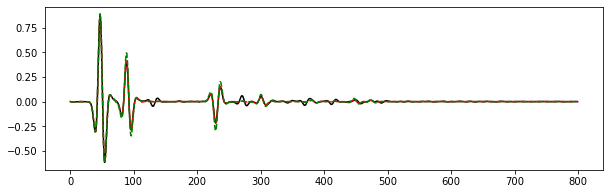

In [40]:
plt.figure(figsize=(10, 3))
plt.plot(Rwav[:, nr//2], 'k')
plt.plot(Rwav_demultipled[:, nr//2], '--r');
plt.plot(Rwav_demultipled_comp[:, nr//2], '--g')

Estimate v- directly **(THIS CURRENTLY DOESN'T WORK)**

In [67]:
def applydatadomain1_onepoint(R, travs, tmax, ir, dt, nfmax, n_iter=10, nsmooth=5):
    nr, _, nt = R.shape
    
    # Window 
    w = np.zeros((nr, 2 * nt-1))
    w[:, int((travs[0]+tmax)/dt):int((travs[1]+tmax)/dt)] = 1
    if nsmooth>0:
        smooth=np.ones(nsmooth)/nsmooth
        w  = filtfilt(smooth, 1, w)    
    Wop = Diagonal(w.T.flatten())

    # Add negative time to operators
    Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
    Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
    Rtwosided_fft = Rtwosided_fft[...,:nfmax]
    Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

    Rwav = R[ir].T
    Rwav = np.apply_along_axis(convolve, 0, Rwav, wav, mode='full')
    Rwav = Rwav[wav_c:][:nt]
    fd_minus = np.concatenate((np.zeros((nt-1, nr)), Rwav))
    
    fd_minus = Wop * fd_plus.ravel()
    fd_minus = fd_plus.reshape(2*nt-1, nr)

    f1_sub_minus = fd_minus.copy()
    f1_sub_minus_updates = np.zeros((n_iter, 2*nt -1, nr))
    f1_sub_minus_updates[0] = fd_minus.copy()

    for i_iter in range(n_iter-1):
        f1_sub_minus = (Wop * Rop * Wop * Rollop * R1op) * f1_sub_minus.ravel()
        f1_sub_minus = f1_sub_minus.reshape(2*nt-1, nr)
        f1_sub_minus_updates[i_iter+1] = f1_sub_minus.copy()
    f1_sub_minus = np.sum(f1_sub_minus_updates, axis=0)  
    f1_sub_minus = w[:, nt-1:].T * Rwav - f1_sub_minus[nt-1:]
    return f1_sub_minus, Rwav, w

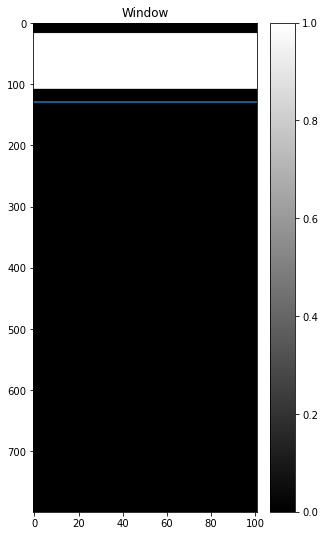

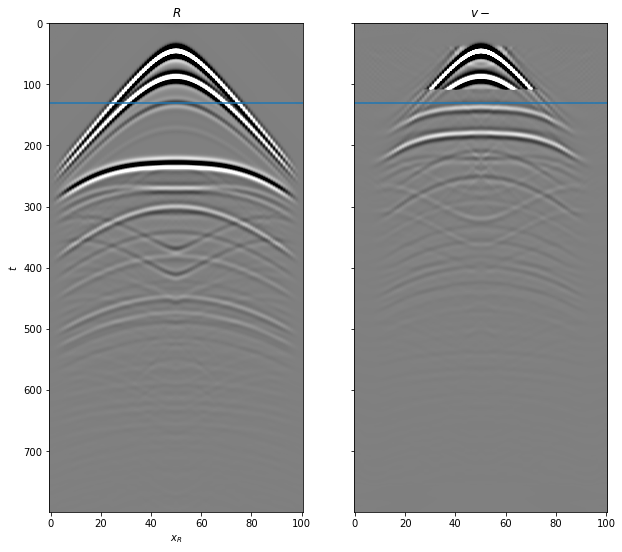

In [68]:
it0 = 130 #47

toff=dt*20
nsmooth=0
f1_minus_f, Rwav_f, w_f = \
    applydatadomain1_onepoint(R, [toff, t[it0]-toff], t[-1], nr//2, dt, nfmax, n_iter=20, nsmooth=nsmooth)

fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w_f[:, nt:].T, cmap='gray')
ax.axhline(it0)
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav_f, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].axhline(it0)
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(f1_minus_f, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].axhline(it0)
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight');

0 / 800
100 / 800
200 / 800
300 / 800
400 / 800
500 / 800
600 / 800
700 / 800


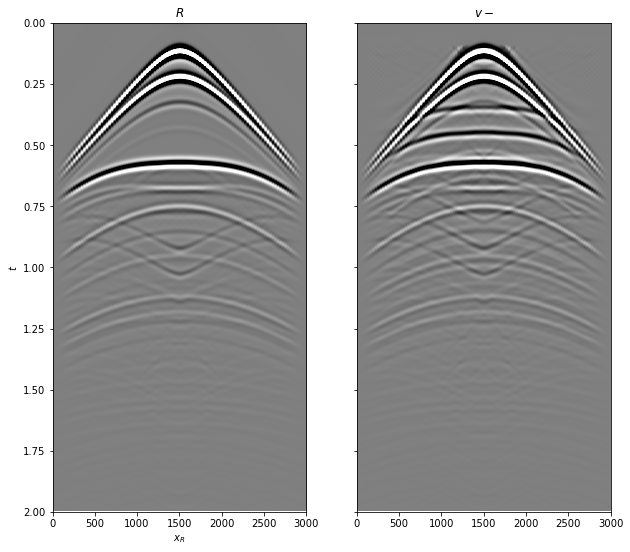

In [59]:
Rwav = np.zeros((nt, nr))
Rwav_demultipled = np.zeros((nt, nr))

for it in range(0, nt):
    if it % 100 == 0:
        print(it, '/', nt)
    f1_minus_tmp, Rwav_tmp, w = \
        applydatadomain1_onepoint(R, [toff, t[it]+toff], t[-1], nr//2, dt, nfmax, n_iter=10, nsmooth=nsmooth)
    Rwav[it] = Rwav_tmp[it]
    Rwav_demultipled[it] = f1_minus_tmp[it]


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(Rwav, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(Rwav_demultipled, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$v-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);